# Проект: вариант 2

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode 
from scipy.stats import norm, shapiro, chi2_contingency
import pandahouse as ph

%matplotlib inline

# Задание 1. A/B–тестирование

## 1. Выгрузка данных

Данные находятся на Яндекс.Диск. Чтобы их выгрузить, используем библиотеки requests и urllib.

In [2]:
# Создаем базовый URL 

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# Создаем частный URL для данных, указываем разделитель csv-файла
links_dic = {
    'groups': ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add': ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks': ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
}

# Соединяем две части в одну ссылку, считываем данные
for csv_filename, link in links_dic.items():
    final_url = base_url + urlencode(dict(public_key=link[0]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=link[1])

## 2. Предварительный анализ данных

### 2.1 Проверка данных


Проверим, есть ли в данных пропущенные значения, дубликаты. Рассмотрим каждый датафрейм:

**groups**

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.dtypes

id      int64
grp    object
dtype: object

In [5]:
groups.id.nunique()

74484

In [6]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
groups.duplicated(subset=['id']).sum()

0

**groups_add**

In [8]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [10]:
groups_add.id.nunique()

92

In [11]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
groups_add.duplicated(subset=['id']).sum()

0

**active_studs**

In [13]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [14]:
active_studs.dtypes

student_id    int64
dtype: object

In [15]:
active_studs.student_id.nunique()

8341

In [16]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [17]:
active_studs.duplicated().sum()

0

**checks**

In [18]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [19]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [20]:
checks.student_id.nunique()

541

In [21]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [22]:
checks.duplicated(subset=['student_id']).sum()

0

В данных нет дубликатов и пропущенных значений.

### 2.2 Анализ

In [23]:
# Соединим таблицы "groups" и "groups_add"
total_group = pd.concat([groups, groups_add])

In [24]:
total_group.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [25]:
total_group.shape[0]

74576

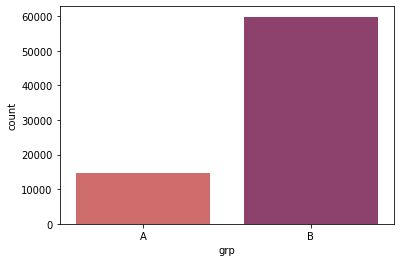

In [26]:
# Количество пользователей в каждой из групп
sns.countplot(x='grp', 
              data=total_group,
              order=['A', 'B'],
              palette='flare')

In [27]:
total_group.grp.value_counts(normalize=True).mul(100)

B    80.297951
A    19.702049
Name: grp, dtype: float64

Большая часть пользователей - из группы В.

Проверим, существуют ли пользователи из датасетов *active_studs* и *checks*, которых **нет** в общем списке *total_group*.

In [28]:
# Кол-во активных пользовтелей, которых нет в общем списке 
active_studs.query(' student_id not in @total_group.id').shape[0]

0

In [29]:
# Кол-во оплативших пользовтелей, которых нет в общем списке 
checks.query(' student_id not in @total_group.id').shape[0]

0

Все пользователи из *active_studs* и *checks* входят в *total_group*. Посмотрим на распределение этих пользователей по **группам**:

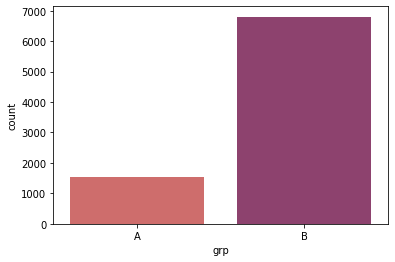

In [30]:
# Для активных в день эксперимента пользователей

sns.countplot(x='grp', 
              data=total_group.query(' id in @active_studs.student_id'),
              palette='flare')

In [31]:
total_group.query(' id in @active_studs.student_id').grp.value_counts(normalize=True).mul(100)

B    81.560964
A    18.439036
Name: grp, dtype: float64

Распределение **активных** в день эксперимента пользователей на группы практически не отличается от распределения общей выборки.

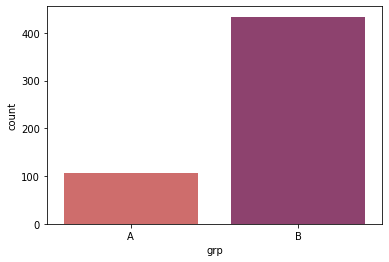

In [32]:
# Для оплативших пользователей

sns.countplot(x='grp', 
              data=total_group.query(' id in @checks.student_id'),
              palette='flare')

In [33]:
total_group.query(' id in @checks.student_id').grp.value_counts(normalize=True).mul(100)

B    80.221811
A    19.778189
Name: grp, dtype: float64

Распределение **оплативших** пользователей на группы практически не отличается от распределения общей выборки.

Рассмотрим **оплативших** пользователей, которые были **активны** в дни эксперимента. 

In [34]:
# Активные пользователи, находящиеся в total_group
active_studs_in_group = total_group.query(' id in @active_studs.student_id').rename(columns={'id':'student_id'})

In [35]:
active_studs_in_group.head()

,student_id,grp
1,1627,A
10,2085,B
12,2215,B
43,3391,A
45,3401,B


In [36]:
# Активные оплатившие пользователи
paid_active_users = active_studs_in_group.merge(checks, 
                                            on='student_id')

In [37]:
paid_active_users.head()

,student_id,grp,rev
0,1627,A,990.0000
1,100300,B,990.0000
2,108270,B,290.0000
3,264473,B,1900.0001
4,274352,B,690.0000


In [38]:
paid_active_users.shape

(392, 3)

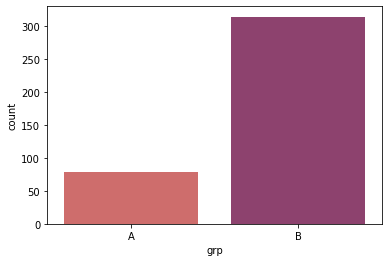

In [39]:
# Распределение на группы для оплативших активных пользователей

sns.countplot(x='grp', 
              data=paid_active_users,
              palette='flare')

In [40]:
paid_active_users.grp.value_counts(normalize=True).mul(100)

B    80.102041
A    19.897959
Name: grp, dtype: float64

Распределение **активных оплативших** пользователей практически не отличается от распределения общей выборки.

Рассмотрим гистограмму **суммы покупок**:

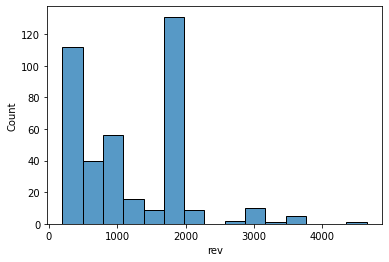

In [41]:
sns.histplot(x='rev',
             data=paid_active_users,
             bins=15)

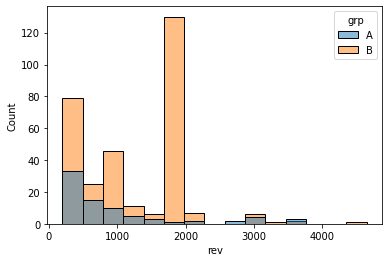

In [42]:
# С делением на группы
sns.histplot(x='rev',
             data=paid_active_users,
             hue='grp',
             bins=15)

Заметим, что распределения далеки от нормального.

Рассмотрим оплативших пользователей, которые **не были активны** в дни эксперимента.

In [43]:
unactive_studs_in_group = total_group.query(' id not in @active_studs.student_id').rename(columns={'id':'student_id'})

In [44]:
unactive_studs_in_group.head()

,student_id,grp
0,1489,B
2,1768,B
3,1783,B
4,1794,A
5,1803,B


In [45]:
# Не активные оплатившие пользователи
paid_unactive_users = unactive_studs_in_group.merge(checks, 
                                            on='student_id')

In [46]:
paid_unactive_users.head()

,student_id,grp,rev
0,3185,B,690.0
1,25973,B,690.0
2,26280,B,690.0
3,100645,B,630.0
4,102534,B,580.0


Не будем рассматривать деления на группы для датасета *paid_unactive_users*, т.к. эти пользователи не участвовали в эксперименте

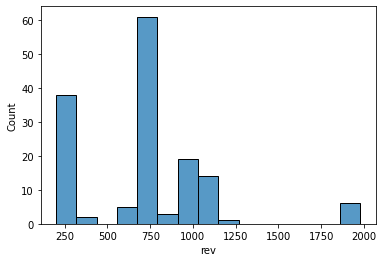

In [47]:
sns.histplot(x='rev',
             data=paid_unactive_users,
             bins=15)

Сравним графики **суммы покупок** активных и неактивных пользователей.

Кол-во покупок в районе 300-700 значительно меньше для неактивных пользователей, чем для активных. 
Также снизилась мода: для активных пользователей она находится в районе 1800, для неактивных - 750.

## 3. Тестирование гипотез

Определимся с метриками:

1. **Конверсия в покупку** - показывает, какая доля пользователей совершила покупку.<br>
*Нулевая гипотеза*: конверсии двух групп независимы и имеют одинаковые функции распределения.


2. **ARPPU** - cредний чек *платящих* пользователей.<br>
*Нулевая гипотеза*: ARPPU двух групп не отличаются.


3. **ARPU** - cредний чек *всех* пользователей.<br>
*Нулевая гипотеза*: ARPU двух групп не отличаются.

### 3.1 Конверсия в покупку (CR Rate)

Используем *active_studs_in_group*. Создадим датафрейм, показывающий, совершал пользователь оплату или нет.

In [48]:
# Все пользователи из checks совершили оплату.

checks['payment'] = 1 

In [49]:
checks.head()

,student_id,rev,payment
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [50]:
# Объединим active_studs_in_group и checks
cr_users = active_studs_in_group.merge(checks[['student_id', 'payment']],
                                                on='student_id',
                                                how='left')\
                                                .fillna(0)


In [51]:
cr_users.head()

,student_id,grp,payment
0,1627,A,1.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


In [52]:
# Переведем payment в целочисленный вид

cr_users['payment'] = cr_users['payment'].astype('int')

In [53]:
cr_users.groupby(['grp', 'payment'], as_index=[False, False]).agg({'student_id':'count'})

student_id
grp payment            
A   0              1460
    1                78
B   0              6489
    1               314

In [54]:
cr_grp_A = cr_users.query('grp =="A"')
cr_grp_B = cr_users.query('grp =="B"')

In [55]:
cr_grp_A.head()

,student_id,grp,payment
0,1627,A,1
3,3391,A,0
13,109623,A,0
15,133678,A,0
23,175944,A,0


In [56]:
cr_grp_B.head()

,student_id,grp,payment
1,2085,B,0
2,2215,B,0
4,3401,B,0
5,22994,B,0
6,26899,B,0


In [57]:
cr_A = cr_grp_A.payment.sum() / cr_grp_A.shape[0]
cr_B = cr_grp_B.payment.sum() / cr_grp_B.shape[0]

In [58]:
round(cr_A, 4)

0.0507

In [59]:
round(cr_B, 4)

0.0462

Заметим, что конверсия у группы А выше. 

Проверим гипотезу H0: конверсии в группах A и B независимы и их распределения одинаковы. Сделаем это с помощью критерия Хи-квадрат.

In [60]:
cr_matrix = np.array([[cr_grp_A.payment.sum(), cr_grp_A.shape[0]-cr_grp_A.payment.sum()],
                          [cr_grp_B.payment.sum(), cr_grp_B.shape[0]-cr_grp_B.payment.sum()]])

In [61]:
cr_matrix

array([[  78, 1460],
       [ 314, 6489]])

In [62]:
p_value = chi2_contingency(cr_matrix, correction=False)[1]

In [63]:
p_value

0.44547028437158964

Т.к. p_value>0.05, мы принимаем нулевую гипотезу. Значит, наша новая механика не влияет на решение о покупке.

### 3.2 Среднее значение суммы покупки только платящих пользователей (ARPPU)

In [64]:
paid_active_users.head()

,student_id,grp,rev
0,1627,A,990.0000
1,100300,B,990.0000
2,108270,B,290.0000
3,264473,B,1900.0001
4,274352,B,690.0000


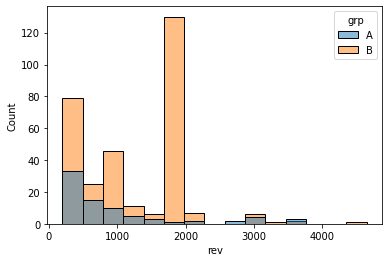

In [65]:
# Обратимся к диаграмме, построенной ранее
sns.histplot(x='rev',
             data=paid_active_users,
             hue='grp',
             bins=15)

In [66]:
grp_A_ARPPU = paid_active_users.query('grp =="A"').rev

In [67]:
grp_B_ARPPU = paid_active_users.query('grp =="B"').rev

In [68]:
# Тест Шапиро-Уилко на нормальность
shapiro(grp_A_ARPPU)
shapiro(grp_B_ARPPU)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

p-value < 0.05 => Отклоняем нулевую гипотезу => Распределение не близко к нормальному, а объем выборки небольшой (392) => t-test использовать не стоит

Используем **Бутстрап**

In [69]:
# Напишем функцию

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_iter = 2000, # количество бутстрап-выборок
    statistic = np.mean, # интересующая статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in range(boot_iter): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

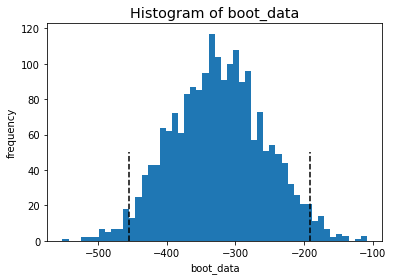

In [70]:
bootstrap_test_1 = get_bootstrap(grp_A_ARPPU, grp_B_ARPPU, boot_iter=2000)

In [71]:
bootstrap_test_1['ci']

,0
0.025,-454.468323
0.975,-190.785996


Ноль не входит в доверительный интервал, значит, различия статистически значимы.

In [72]:
bootstrap_test_1['p_value']

1.9170575518869728e-06

p-value < 0.05 => Отклоняем нулевую гипотезу. Это означает, что новая механика оплаты повлияла на то, сколько в среднем тратит платящий пользователь.

### 3.3 Среднее значение суммы покупки для всех пользователей (ARPU)

Нужно создать таблицу, которая учитывает всех активных пользователей и сумму их покупок.

In [73]:
# Объединим active_studs_in_group и checks
arpu_users = active_studs_in_group.merge(checks[['student_id', 'rev']],
                                                on='student_id',
                                                how='left')\
                                                .fillna(0)

In [74]:
arpu_users.head()

,student_id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


Посмотрим на распределение суммы покупок в обеих группах.

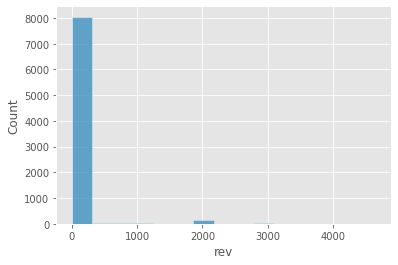

In [75]:
sns.histplot(x='rev',
             data=arpu_users,
             bins=15)

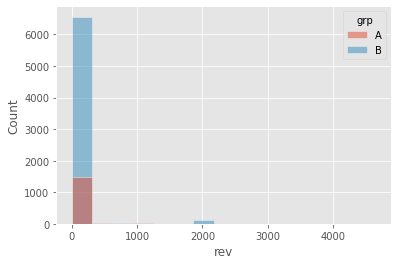

In [76]:
sns.histplot(x='rev',
             data=arpu_users,
             hue='grp',
             bins=15)

Мы видим, что небольшая доля людей совершила покупки. Проведём **bootstrap**.

In [77]:
grp_A_ARPU = arpu_users.query('grp =="A"').rev
grp_B_ARPU = arpu_users.query('grp =="B"').rev

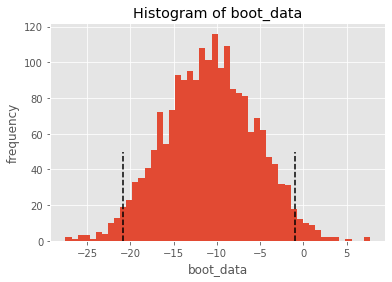

In [78]:
bootstrap_test_2 = get_bootstrap(grp_A_ARPU, grp_B_ARPU, boot_iter=2000)

In [79]:
bootstrap_test_2['ci']

,0
0.025,-20.890641
0.975,-0.957776


In [80]:
bootstrap_test_1['p_value']

1.9170575518869728e-06

P-value < 0.05 => Отклоняем нулевую гипотезу. Это означает, что новая механика оплаты повлияла на то, сколько в среднем тратят все пользователи.

## Итог

Новая механика оплаты не повлияет на долю платящих пользователей (CR). Однако, она увеличит средний чек (ARPU и ARPPU). <br>
Следовательно, новую механику **стоит запускать** на всех пользователей.

# Задание 2. SQL

In [81]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### 2.1 Очень усердные ученики

In [82]:
a = '''
SELECT st_id AS ID,    
       SUM(correct) AS Score       
    FROM default.peas  
    WHERE  
        toStartOfMonth(timest) == toStartOfMonth(now())  
    GROUP BY  
        st_id  
    HAVING
        SUM(correct) >= 20 
        '''
a_test = ph.read_clickhouse(query=a, connection=connection_default)
a_test        
        
     

,ID,Score


Таблица пустая, т.к. в таблице находятся данные только за октябрь 2021 года. Уберем требование о текущем месяце и посмотрим на результат запроса:

In [83]:
b = '''
SELECT st_id AS ID,    
       SUM(correct) AS Score       
    FROM default.peas  
    GROUP BY  
        st_id  
    HAVING
        SUM(correct) >= 20 
        '''
b_test = ph.read_clickhouse(query=b, connection=connection_default)
b_test        
        

,ID,Score
0,700123,126
1,171209,26
2,219630,53
3,416918,26
4,877738,22
...,...,...
131,375731,24
132,71465,38
133,936163,29
134,790532,22


### 2.2 Оптимизация воронки

In [84]:
с = '''
SELECT 
       test_grp,
       SUM(rev.money)/uniqExact(studs.st_id) as ARPU,
       SUMIf(rev.money, active_studs.active>10)/uniqExactIf(studs.st_id, active_studs.active>10) AS ARPAU,
       uniqExactIf(studs.st_id, rev.money > 0)/uniqExact(studs.st_id)*100 AS CR,
       uniqExactIf(studs.st_id, active_studs.active > 10 and rev.money > 0)/uniqExactIf(studs.st_id, active_studs.active > 10)*100 AS CR_active,
       uniqExactIf(studs.st_id, active_studs.math_active > 10 and rev.subject = 'Math' and rev.money > 0)*100/
                    uniqExactIf(studs.st_id, active_studs.math_active > 10) AS CR_math

       
FROM default.studs AS studs

FULL JOIN default.final_project_check AS rev
ON studs.st_id=rev.st_id

FULL JOIN (
    SELECT st_id,
           SUM(correct) AS active,
           SUMIf(correct, subject='Math') AS math_active
    FROM default.peas
    GROUP BY st_id) AS active_studs
ON studs.st_id=active_studs.st_id    
    
GROUP BY test_grp
    '''
с_test = ph.read_clickhouse(query=с, connection=connection_default)
с_test

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.983607,10393.700787,4.918033,11.023622,6.896552
1,pilot,11508.474576,29739.583333,10.847458,26.041667,10.526316


# Задание 3. Python

In [85]:
def update_df(df, new_df):
    
    # Заменим названия колонок в случае, если они не совпадают
    
    new_df = new_df.rename(columns= {new_df.columns[0]: 'id', new_df.columns[1]: 'grp'})
    
    # Соединим первоначальную таблицу с новой
    df_total = pd.concat([df, new_df])
    
    # Создадим таблицу с данными о всех пользователях: 
    # группа (A или B), активность в дни эксперимента (0 или 1), совершал ли покупки (0 или 1), сумма покупок
    
    act_studs = active_studs.copy()
    act_studs['active'] = 1
    act_studs = act_studs.rename(columns = {'student_id': 'id'})
    df_active =  df_total.merge(act_studs, on='id', how='left').fillna(0)
    df_active['active'] = df_active['active'].astype('int')
    
    ch = checks.copy()
    ch['payment'] = 1
    ch = ch.rename(columns = {'student_id': 'id'})
    df_active_pay =  df_active.merge(ch, on='id', how='left').fillna(0)
    df_active_pay['payment'] = df_active_pay['payment'].astype('int')
    
    
    # Найдем CR в покупку для активных пользователей обеих групп
    
    a_active = df_active_pay.query('active == 1 and grp == "A"')
    b_active = df_active_pay.query('active == 1 and grp == "B"')
    
    a_cr = round(a_active.payment.sum() / (a_active.shape[0]) * 100, 2)
    b_cr = round(b_active.payment.sum() / (b_active.shape[0]) * 100, 2)
    
    

    # Найдем ARPPU для обеих групп активных пользователей
    a_arppu = round(a_active.rev.sum() / a_active.payment.sum(), 2)
    b_arppu = round(b_active.rev.sum() / b_active.payment.sum(), 2)
    
    # Найдем ARPU для обеих групп активных пользователей
    a_arpu = round(a_active.rev.mean(), 2)
    b_arpu = round(b_active.rev.mean(), 2)

    
    print(f'Конверсия в покупку для группы A: {a_cr} %')
    print(f'Конверсия в покупку для группы B: {b_cr} %'+'\n')
    print(f'ARPPU для группы A: {a_arppu}')
    print(f'ARPPU для группы B: {b_arppu}'+'\n')
    print(f'ARPU для группы A: {a_arpu}')
    print(f'ARPU для группы B: {b_arpu}')
    
    return {'Group': ['A', 'B'],
            'CR': [a_cr, b_cr],
            'ARPPU': [a_arppu, b_arppu],
            'ARPU': [a_arpu, b_arpu]}    

In [86]:
update_df(groups, groups_add)

Конверсия в покупку для группы A: 5.07 %
Конверсия в покупку для группы B: 4.62 %

ARPPU для группы A: 933.59
ARPPU для группы B: 1257.88

ARPU для группы A: 47.35
ARPU для группы B: 58.06


{'Group': ['A', 'B'],
 'CR': [5.07, 4.62],
 'ARPPU': [933.59, 1257.88],
 'ARPU': [47.35, 58.06]}

In [87]:
def plot(df):
    
    # Создаем датафрейм с метриками
    plot_df = pd.DataFrame(df)
    
    sns.set_theme(style="white", palette="pastel")
    fig, axs = plt.subplots(ncols=3, figsize=(19, 5))

    sns.barplot(x="Group", y="CR", data=plot_df, ax=axs[0]).set_title('CR')
    sns.barplot(x="Group", y="ARPPU", data=plot_df, ax=axs[1]).set_title('ARPPU')
    sns.barplot(x="Group", y="ARPU", data=plot_df, ax=axs[2]).set_title('ARPU')

Конверсия в покупку для группы A: 5.07 %
Конверсия в покупку для группы B: 4.62 %

ARPPU для группы A: 933.59
ARPPU для группы B: 1257.88

ARPU для группы A: 47.35
ARPU для группы B: 58.06


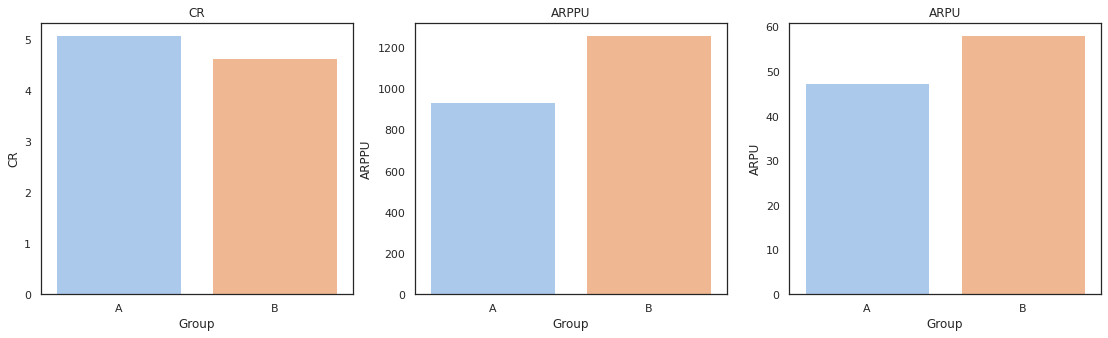

In [88]:
plot(update_df(groups, groups_add))